In [17]:
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt

In [30]:
stock_tickers = pd.read_csv('data/SP500_tickers_clean.csv', index_col=0)

In [ ]:
"""
! losses viz
create dataframe for loading results
cols: all 500 tickers
rows: each epochs losses (should we train 50 epochs on ALL tickers? depends on visualization)
maybe DF is a bad idea, what kind of viz do I want to show anyway? probably not comparing them...
individual viz at max, we can do a dict of avg loss for each ticker - bar plot from that - also divide into folds
? dict{fold1: {ticker1: loss, ticker2: loss}, fold2: {ticker1: loss, ticker2: loss}


"""

In [31]:
def GetLossesFromJSON(fold, ticker, exp_dir):
    result_dir = f"{exp_dir}/fold{fold}/{ticker}/model_losses.json"
    with open(result_dir, 'r') as f:
        results = json.load(f)
    return results['train_losses'], results['val_losses']

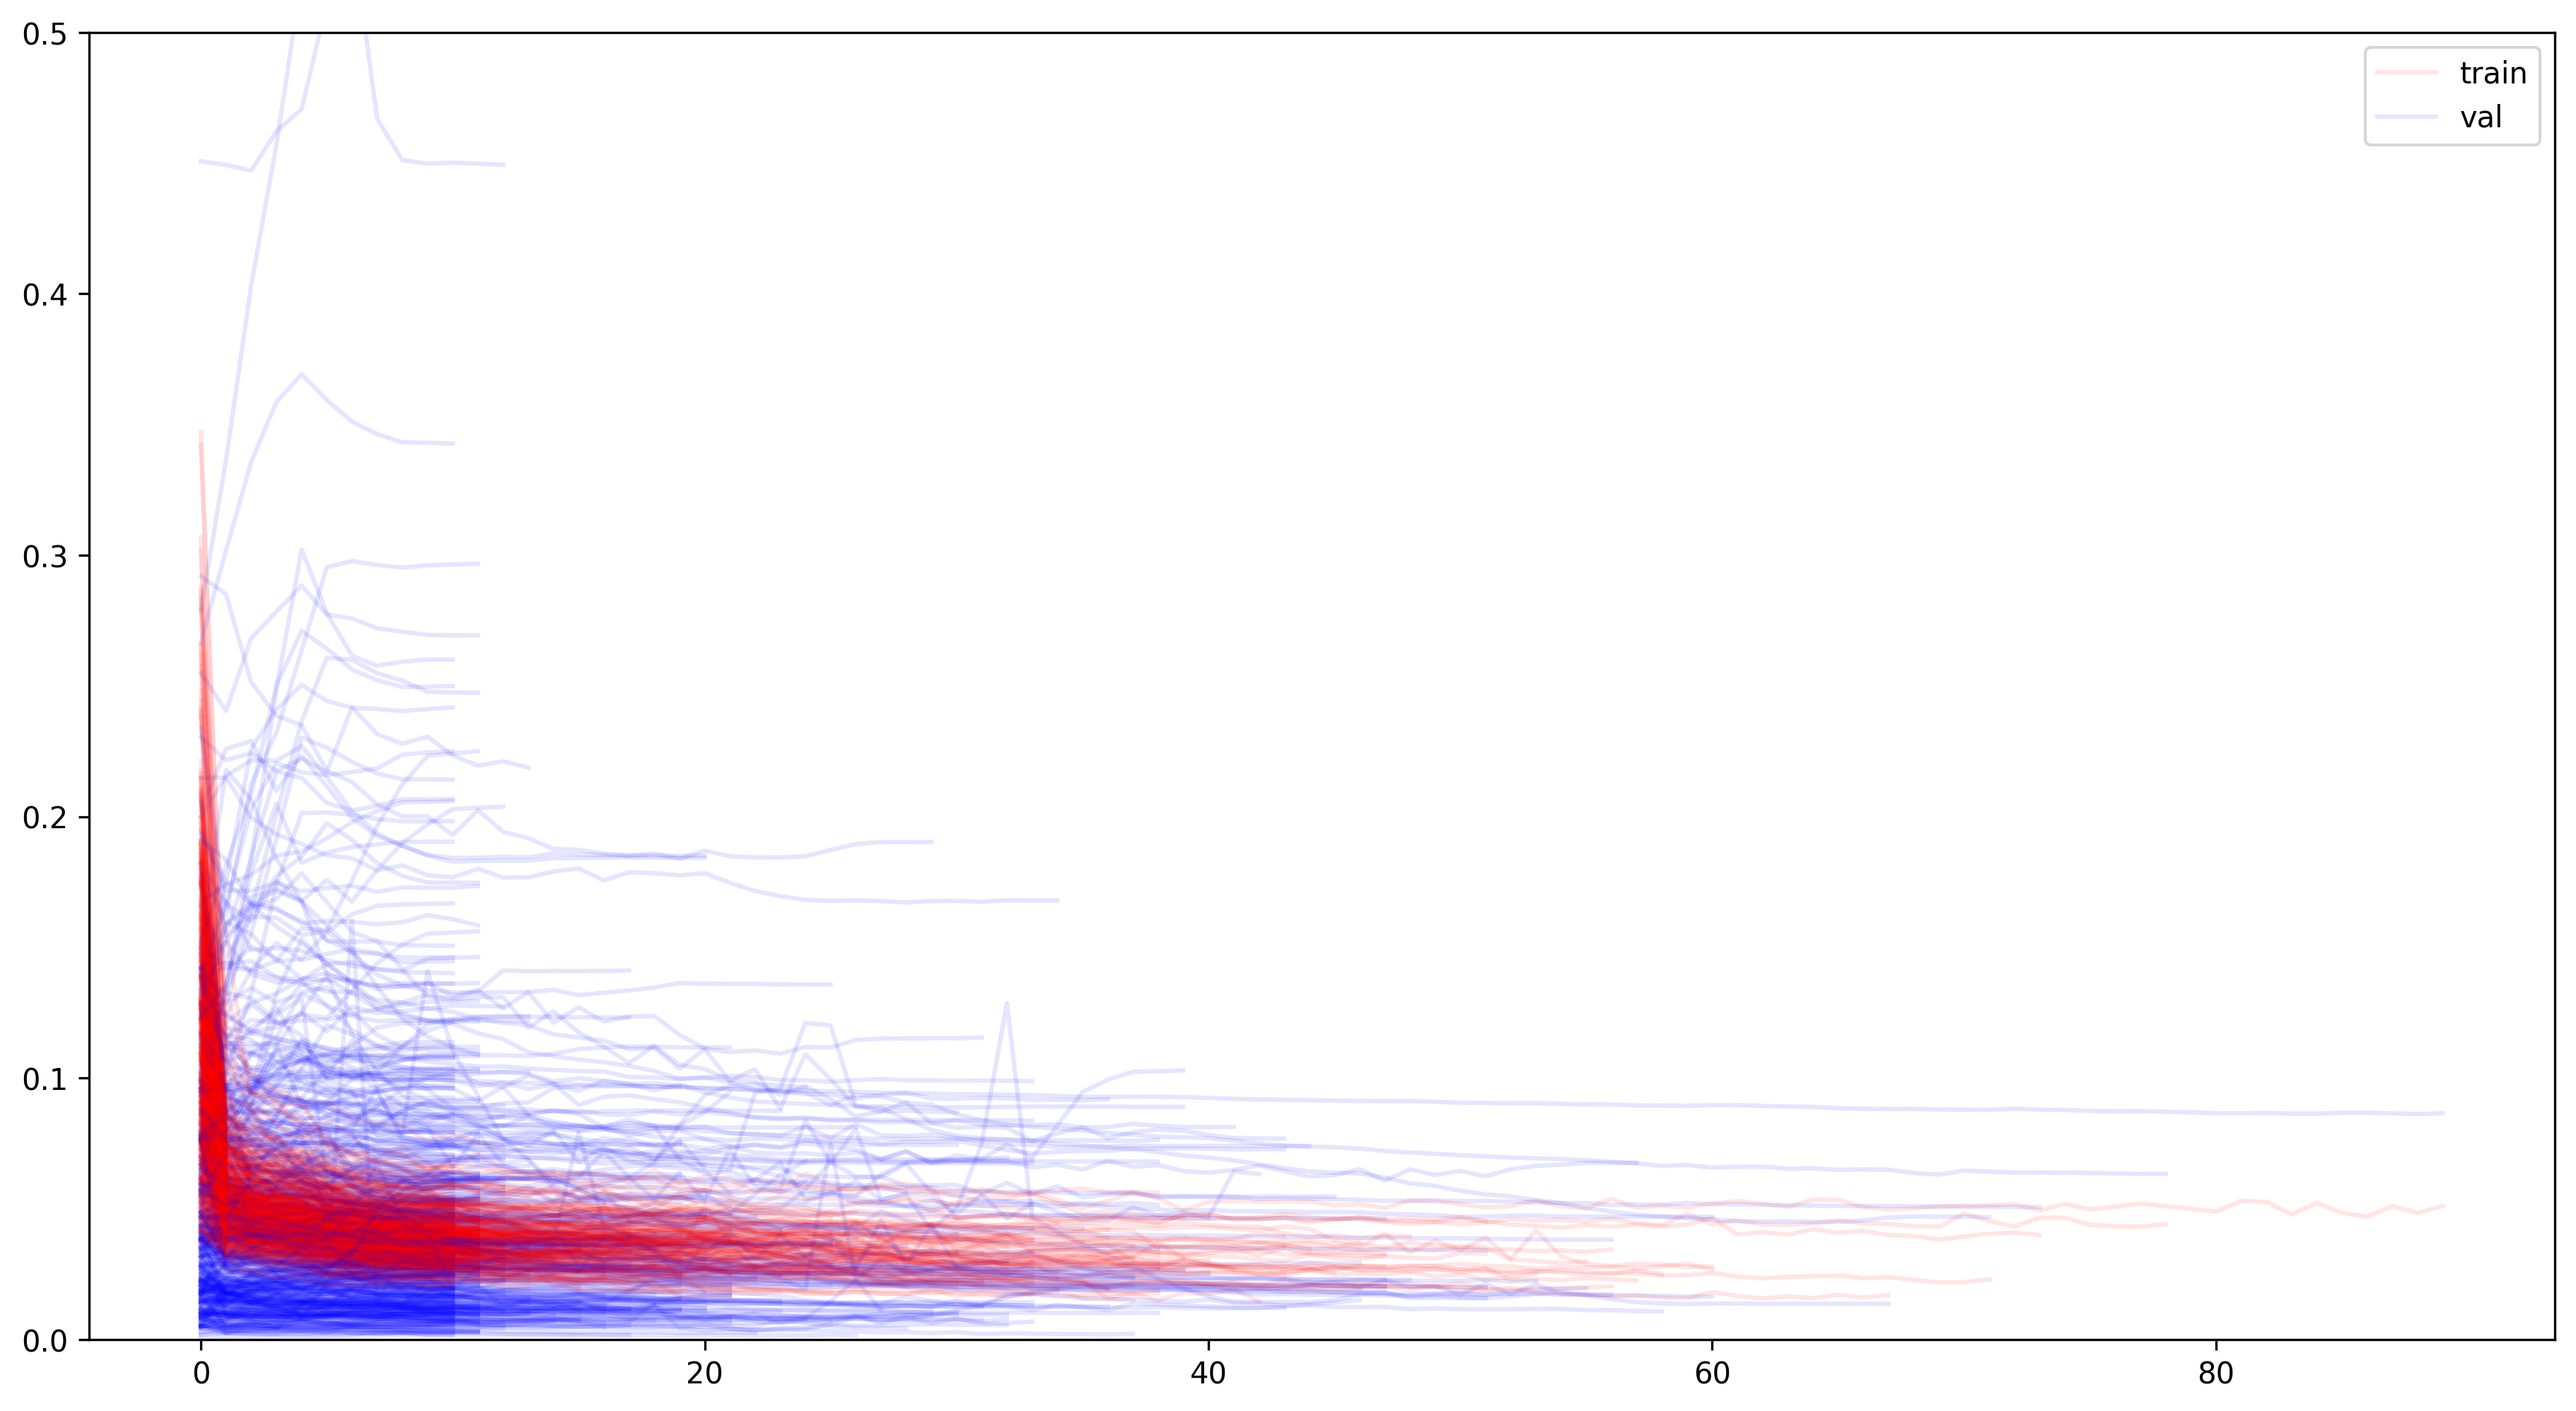

In [39]:
plt.figure(figsize=(15, 8), dpi=300)

for ticker in stock_tickers['Ticker']:
    train_losses, val_losses = GetLossesFromJSON(1, ticker, exp_dir="exp")
    plt.plot(train_losses, color="red", alpha=0.1)
    plt.plot(val_losses, color="blue", alpha=0.1)

# manual coloring, blue for val, red for train in legend
plt.ylim(0, 0.5)
plt.legend(["train", "val"])


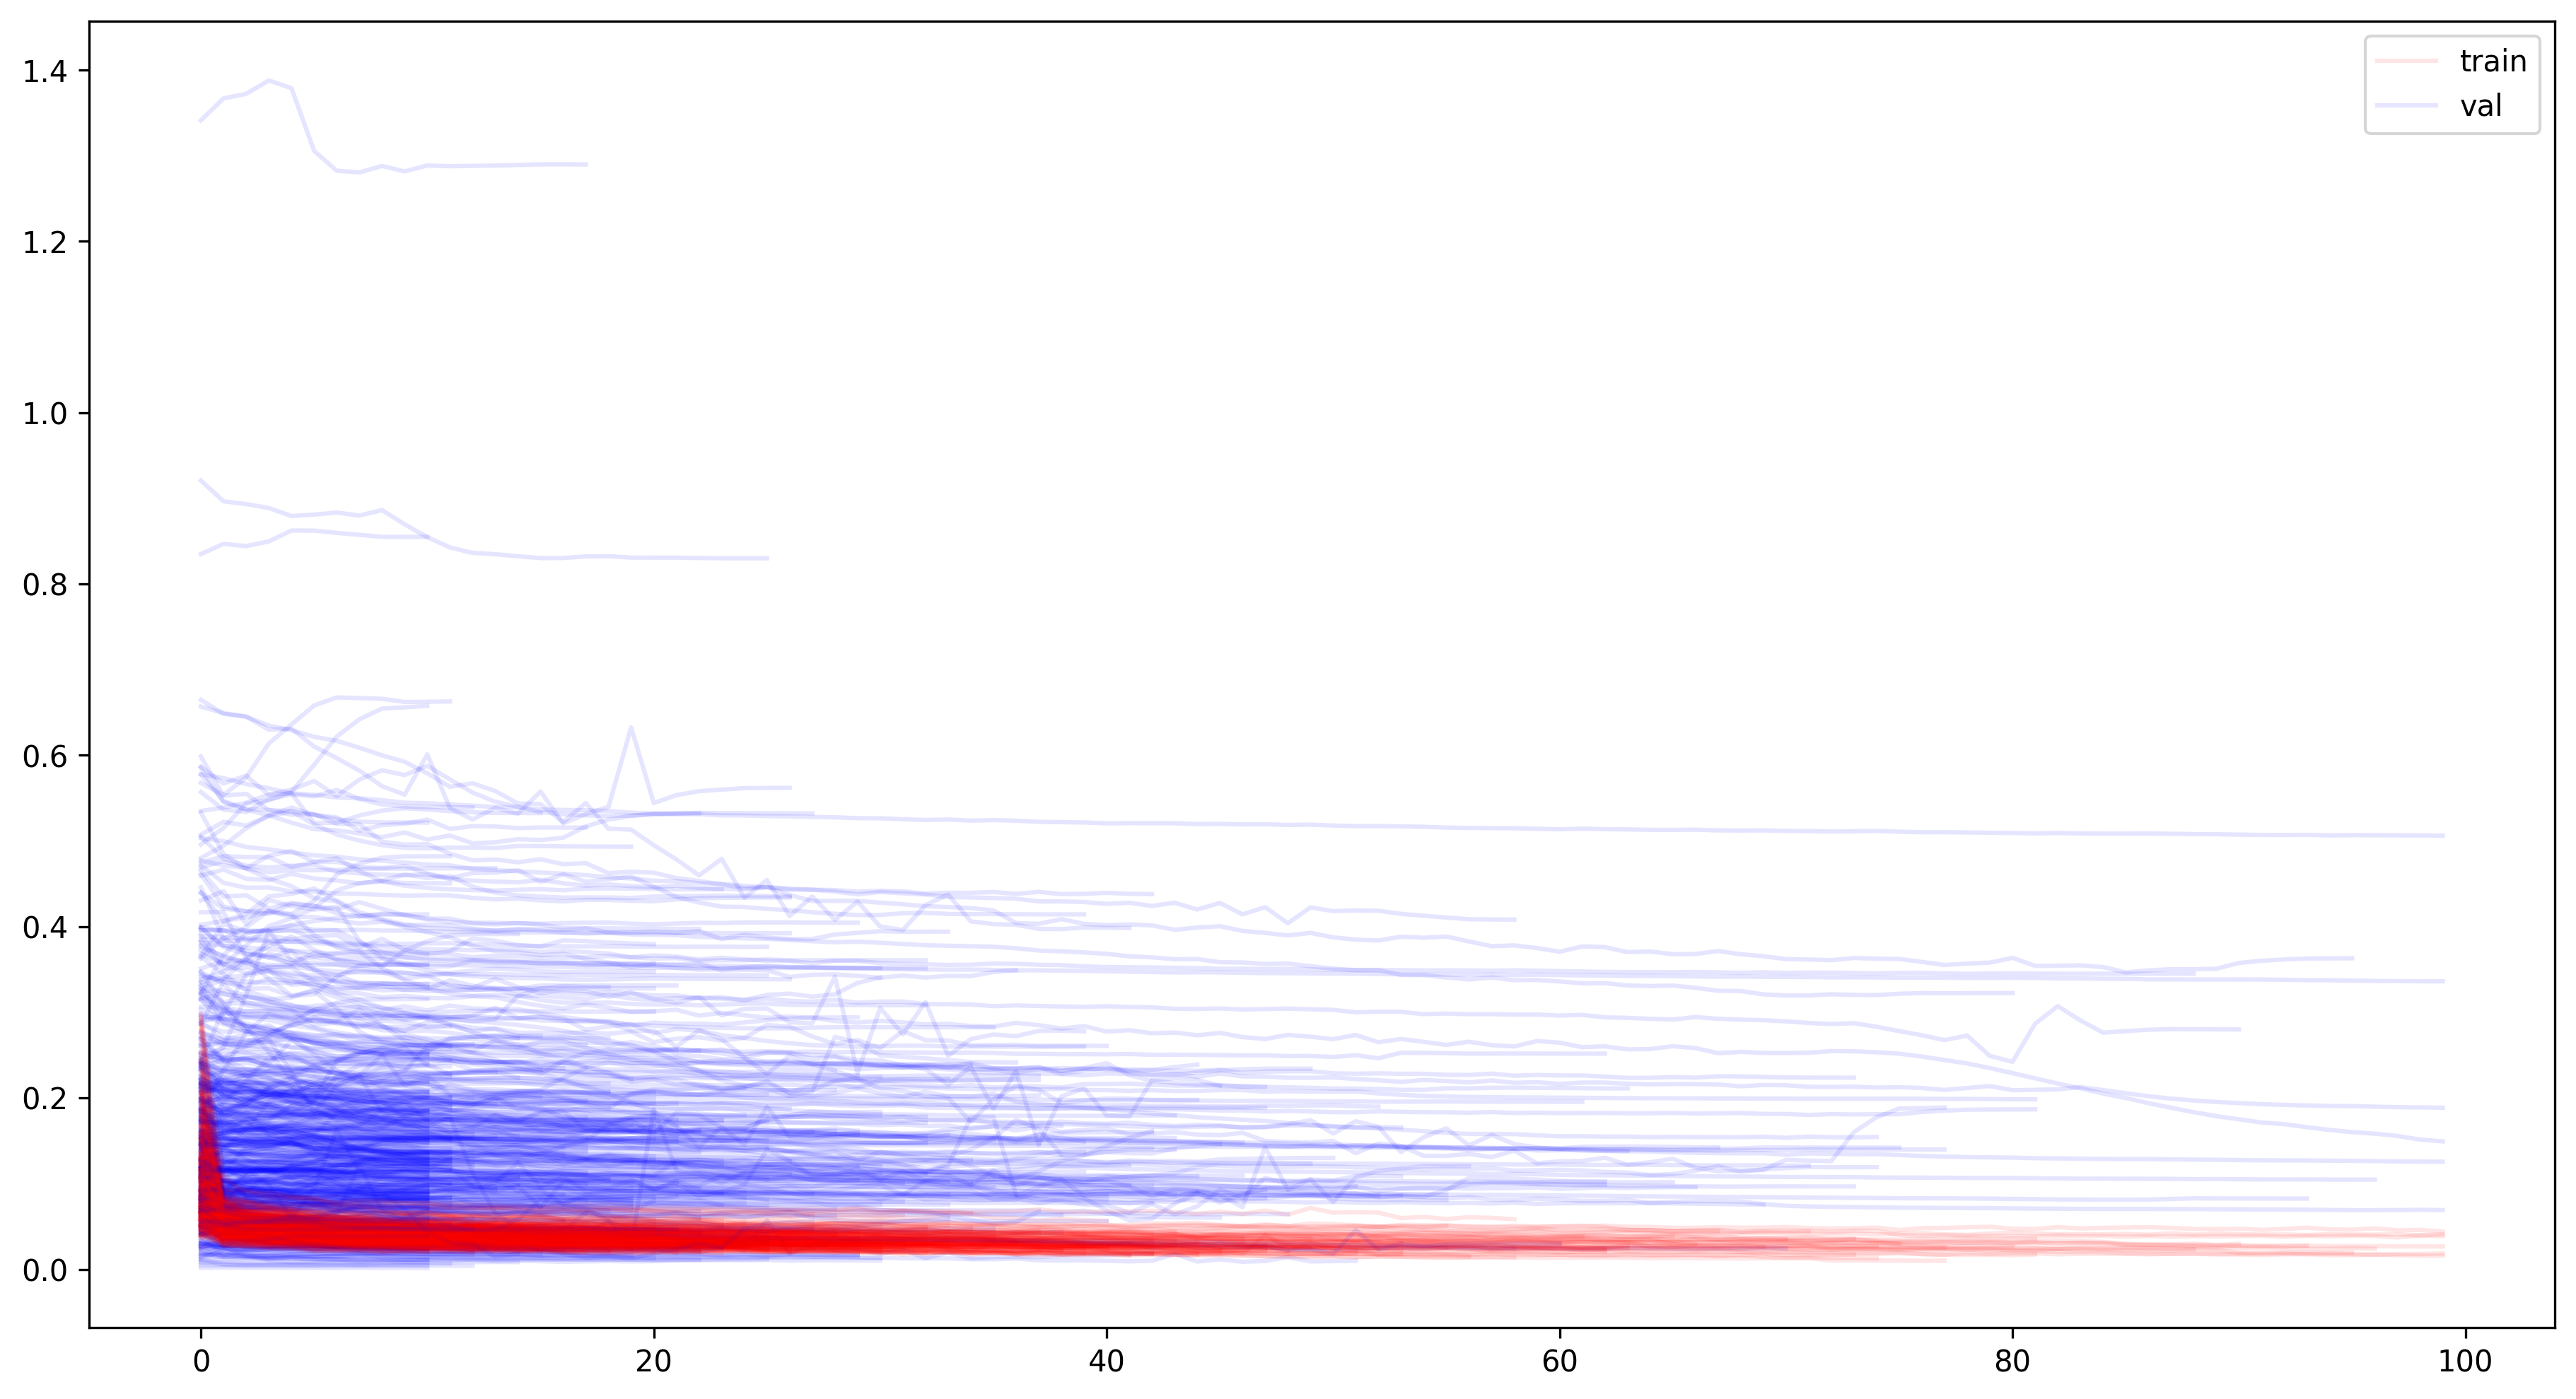

In [43]:
plt.figure(figsize=(15, 8), dpi=300)

for ticker in stock_tickers['Ticker']:
    train_losses, val_losses = GetLossesFromJSON(2, ticker, exp_dir="exp")
    plt.plot(train_losses, color="red", alpha=0.1)
    plt.plot(val_losses, color="blue", alpha=0.1)

# manual coloring, blue for val, red for train in legend
# plt.ylim(0, 1)
plt.legend(["train", "val"])
